In [1]:
import os
import json
import gzip

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.Seq import Seq
from sqlalchemy import create_engine

if os.getcwd().endswith('notebook'):
    os.chdir('..')
    
from preprocessing.sequence_utils import is_valid_cds

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
db_path = os.path.join(os.getcwd(), 'data/condensed_traits/db/seq.db')
engine = create_engine(f'sqlite+pysqlite:///{db_path}')

## Number of sequences

In [4]:
seq_per_species_query = """
select 
    species_taxid, 
    count(*) as sequence_count,
    min(length) as min_length,
    max(length) as max_length,
    avg(length) as avg_length
from sequences
group by species_taxid
""" 
sequence_count_per_species = pd.read_sql(seq_per_species_query, engine).set_index('species_taxid', drop=True)

In [5]:
sequence_count_per_species.head()

,sequence_count,min_length,max_length,avg_length
species_taxid,,,,
7,7053,1,18146,913.653481
9,883,1,11750,857.484711
11,4517,1,14127,956.019261
14,2641,1,38224,927.024233
19,5141,1,16057,856.794982


In [6]:
min_s = sequence_count_per_species['sequence_count'].min()
max_s = sequence_count_per_species['sequence_count'].max()
avg_s = sequence_count_per_species['sequence_count'].mean()
print('Sequence count')
print(f'Minimum: {min_s:,}')
print(f'Maximum: {max_s:,}')
print(f'Mean: {avg_s:,.0f}')

Sequence count
Minimum: 883
Maximum: 21,020
Mean: 5,476


## Sequence lengths

In [7]:
min_s = sequence_count_per_species['min_length'].min()
max_s = sequence_count_per_species['max_length'].max()
print('Sequence length')
print(f'Minimum: {min_s:,}')
print(f'Maximum: {max_s:,}')

Sequence length
Minimum: 1
Maximum: 87,609


In [8]:
avg_sequence_length = pd.read_sql(
    'select avg(length) as avg_seq_l from sequences', 
    engine,
).iloc[0]['avg_seq_l']
print(f'Average sequence length: {avg_sequence_length:,.0f}')

Average sequence length: 893


In [9]:
sequence_lengths = pd.read_sql('select length from sequences', engine)['length'].values

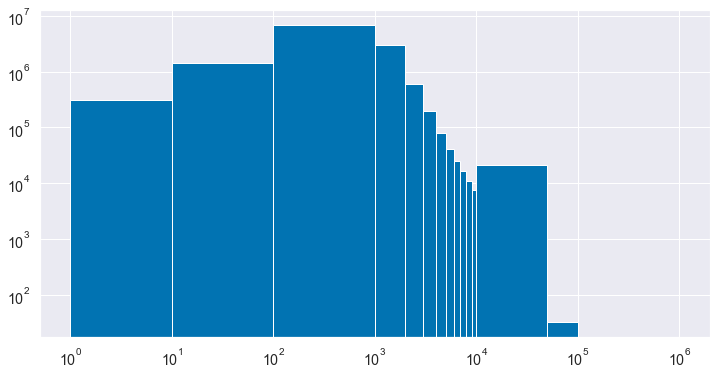

In [10]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
bins = [1, 10, 100, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 50000, 1e5, 1e6]
ax.set_xscale('log');
ax.hist(sequence_lengths, bins=bins, log=True);

In [12]:
q = """
select 
    species_taxid, 
    cast(sum(length) / 1000 as integer) as cds_total_length
from sequences
where sequence_type = 'CDS'
group by species_taxid
""" 
s1 = pd.read_sql(q, engine)

In [13]:
q = """
select 
    species_taxid, 
    cast(sum(length) / 1000 as integer) as non_coding_total_length
from sequences
where sequence_type = 'non_coding'
group by species_taxid
""" 
s2 = pd.read_sql(q, engine)

In [14]:
s = pd.merge(s1, s2, on='species_taxid').set_index('species_taxid', drop=True)
s.head()

,cds_total_length,non_coding_total_length
species_taxid,,
7,4829,1596
9,534,214
11,3217,1086
14,1829,604
19,3184,1202


In [15]:
s['coding_ratio'] = s.apply(
    lambda row: row['cds_total_length'] / (row['cds_total_length'] + row['non_coding_total_length']), 
    axis=1,
)

In [16]:
s

,cds_total_length,non_coding_total_length,coding_ratio
species_taxid,,,
7,4829,1596,0.751595
9,534,214,0.713904
11,3217,1086,0.747618
14,1829,604,0.751747
19,3184,1202,0.725946
...,...,...,...
1813871,4681,1821,0.719932
1833852,2700,1186,0.694802
1835254,1890,596,0.760257


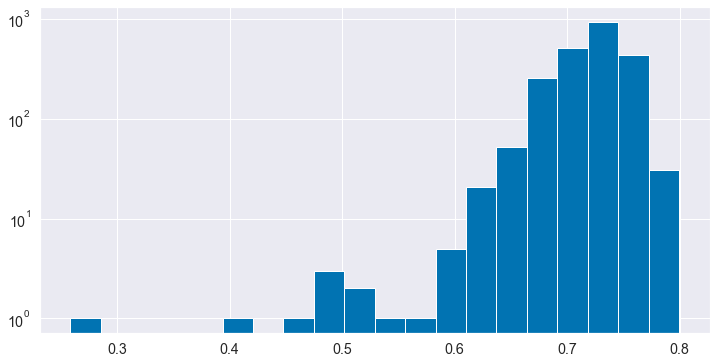

In [17]:
_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist(s['coding_ratio'], bins=20, log=True);